# 21. QLS - Confidence Intervals

## Sample vs. Population

Sample variables and population variables are different. Generally, sample variables are the only ones that can be calculated, but population variables are the ones you'd like to make conclusions about.

The sample variables can be used to estimate the population variables. This is achieved through confidence intervals (the accuracy of the sample estimate relative to the population variable).

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sb
sb.set(rc={'figure.figsize':(11.7,8.27)})
sb.set_style("whitegrid", {"grid.color":".6", "grid.linestyle":":"})

## Confidence Interval

Estimating the average height of a woman in the USA might be done by measuring 10 women and inferring that the mean of that sample is close to the population.

In [2]:
# setting a seed so re-runs are consistent
np.random.seed(10)

# defining "true" population parameters (which should be unknown)
POP_MU = 64
POP_SIGMA = 5

# generate sample from population distribution
sample_size = 10
heights = np.random.normal(POP_MU, POP_SIGMA, sample_size)
print(heights)
mean_height = np.mean(heights)
print("Sample mean: ", mean_height)

[70.65793252 67.57639487 56.27299854 63.95808075 67.10667987 60.3995722
 65.32755793 64.54274263 64.02145715 63.12699895]
Sample mean:  64.29904154070394


Unfortunately, the sample mean isn't very useful, as it's relationship to the true mean is unknown. To get a sense of how it *might* relate, the variance of the sample can be observed. Higher variance can indicate instability and uncertainty.

In [3]:
print("Sample standard deviation: ", np.std(heights))

Sample standard deviation:  3.759878018454642


This still doesn't help that much, to really get a sense of how the sample mean relates to the data, the **standard error** needs to be computed. It's a measure of the variance of the sample mean.

**Note**: Computing a standard error carries the assumption that the sampling process is <u>unbiased</u>, and that the data is normally distributed and independent. If these conditions aren't met, then the standard error will be biased. There are methods to test and correct for this.

The formula for the standard error of the mean is:

$$
SE = \frac{S_{x}}{\sqrt{n}}
$$

where $S_{x}$ is the sample standard deviation and $n$ is the sample size.

In [4]:
SE = (np.std(heights)/np.sqrt(sample_size))
print("Standard error: ", SE)

Standard error:  1.1889778262717268


There's a function in `scipy`'s `stats` library for calculating the standard error. Note that this function contains a degrees of freedom correction that is often not needed (as it's virtually irrelevant for large samples). This correction can be omitted by setting the parameter `ddof` to 0.

In [5]:
stats.sem(heights, ddof=0)

np.float64(1.1889778262717268)

Assuming the data is normally distributed, then the standard error can be used to calculate the confidence interval. To do this, a confidence level must be set. For example, 95%, then it's crucial to determine how many standard deviations are contained within 95% of the mass. Turns out that, on a standard normal distribution, 95% of the mass lies between $\pm 1.96$.

When the sample size is large enough (generally $n > 30$) the Central Limit Theorem applies and normality can be safely assumed. If sample sizes are smaller, a safer approach is to use a $t$-distribution with specific degrees of freedom.

The actual calculation for the values is done through the use of a cumulative distribution function (CDF). If you're unfamiliar with CDFs, inverse CDFs, and their accompanying PDFs, you can read about them [here](https://en.wikipedia.org/wiki/Cumulative_distribution_function) and [here](https://en.wikipedia.org/wiki/Probability_density_function). Look at [this](https://en.wikipedia.org/wiki/Student%27s_t-distribution) for more information on the $t$-distribution.

**Note**: Be weary when applying the CLT as many datasets in finance are fundamentally non-normal, and it's not safe to apply the theorem casually or without subtlety.

The 95% mass bounds can be visualized here:

/home/venatio/documents/projects/quantopian_lectures/.venv/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/venatio/documents/projects/quantopian_lectures/.venv/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


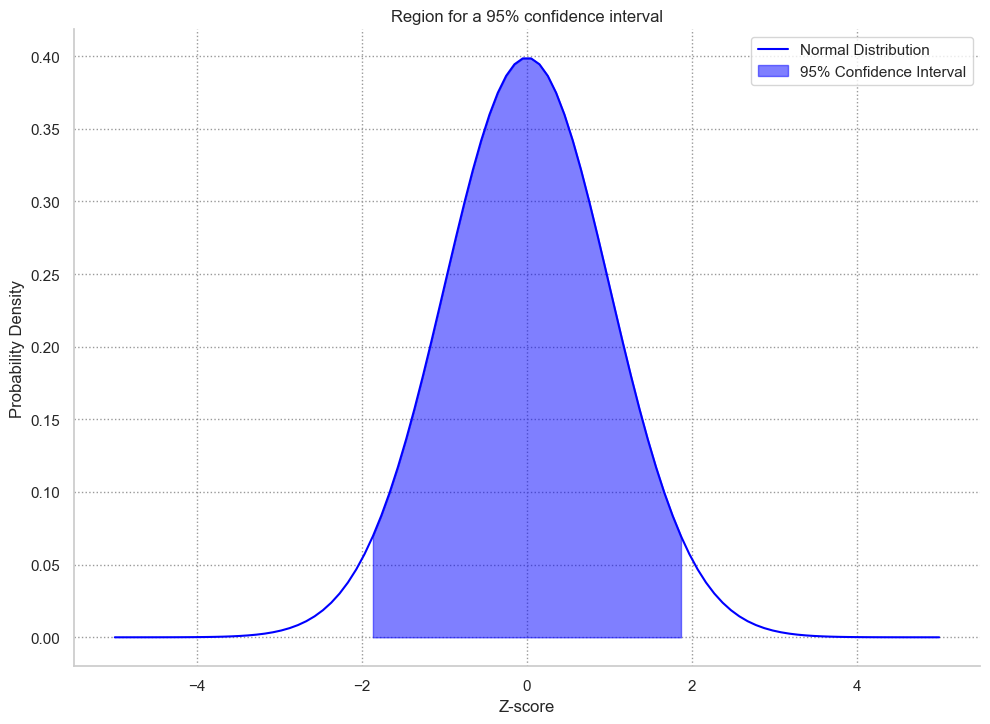

In [6]:
# x-axis
x = np.linspace(-5,5,100)
# normal distribution
y = stats.norm.pdf(x,0,1)
ax = sb.lineplot(x=x, y=y, label='Normal Distribution', color='blue')

# calculate the critical values for a 95% confidence level
alpha = 0.05
critical_value = stats.norm.ppf(1 - alpha / 2)

ax.fill_between(x, y, where=(-critical_value < x) & (x < critical_value), color='blue', alpha=0.5, label='95% Confidence Interval')
ax.set_title('Region for a 95% confidence interval')
ax.set_xlabel('Z-score')
ax.set_ylabel('Probability Density')
ax.legend()

sb.despine()

Now, rather than reporting the sample mean without any sense of the probability of it being correct, an interval can be computed to gain some level of confidence that the population mean lies in that interval. Assuming normality, the interval $CI^{95 \%} = \left( \overline{X} - 1.96 \cdot SE, \overline{X} + 1.96 \cdot SE \right)$ where $\mu \in CI$ at 95% of the test runs.

Note that the 95% confidence refers to the fact that, over many runs of the confidence interval, in 95% of those runs the true value will be within the interval. So, in fact, there is no way to assess the probability that one interval contains the population mean given a single sample.

The following plot demonstrates the previous statements.

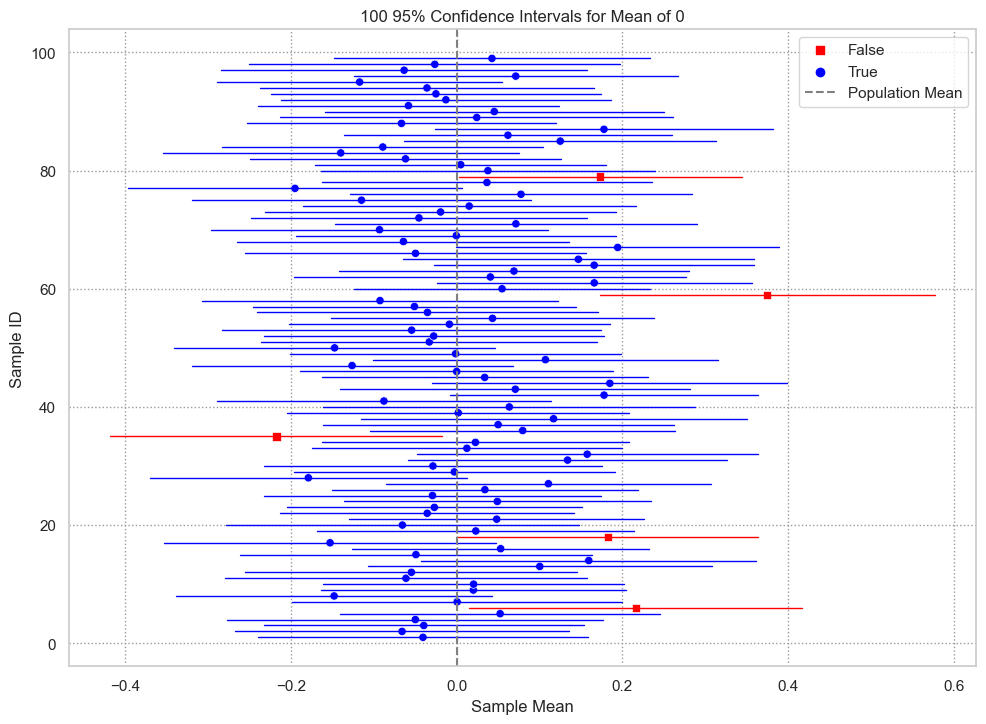

In [14]:
# Seed and sample setup
np.random.seed(8309)
n = 100  # number of samples
samples = [np.random.normal(loc=0, scale=1, size=100) for _ in range(n)]

# Prepare data for independent confidence intervals
ci_data = []
for i in np.arange(1, n, 1):
    sample_mean = np.mean(samples[i])  # calculate sample mean
    se = stats.sem(samples[i])  # calculate standard error
    h = se * stats.t.ppf((1 + 0.95) / 2, len(samples[i]) - 1)  # t-value
    sample_ci = [sample_mean - h, sample_mean + h]
    in_ci = (sample_ci[0] <= 0) and (0 <= sample_ci[1])  # Check if population mean is in CI
    ci_data.append({
        "lower": sample_ci[0],
        "upper": sample_ci[1],
        "mean": sample_mean,
        "sample_id": i,
        "contains_mean": in_ci
    })

# Convert to DataFrame
df = pd.DataFrame(ci_data)

# Separate plotting of each confidence interval
plot = sb.scatterplot(
    data=df,
    x="mean",
    y="sample_id",
    hue="contains_mean",
    palette={True: "blue", False: "red"},
    style="contains_mean",
    markers={True: "o", False: "s"},
    legend="full"
)

# Draw confidence interval lines manually
for _, row in df.iterrows():
    color = "blue" if row["contains_mean"] else "red"
    plot.plot(
        [row["lower"], row["upper"]],
        [row["sample_id"], row["sample_id"]],
        color=color,
        linewidth=1
    )

# Add vertical line for population mean
plot.axvline(x=0, linestyle="--", color="gray", label="Population Mean")
plot.set_title("100 95% Confidence Intervals for Mean of 0")
plot.set_xlabel("Sample Mean")
plot.set_ylabel("Sample ID")

# Show legend and tidy up
plot.legend(loc="best")

Since the sample size is small, yet normality is assumed, then a $t$-test is sensible.

In [16]:
t_crit_val = stats.t.ppf((1+0.95)/2, 10 - 1)
print(f"Sample mean height: {mean_height}")
print(f"t Critical value: {t_crit_val}")
print(f"Standard error: {SE}")
print(f"Confidence interval: ({mean_height - t_crit_val*SE}, {mean_height + t_crit_val*SE})")

Sample mean height: 64.29904154070394
t Critical value: 2.2621571628540993
Standard error: 1.1889778262717268
Confidence interval: (61.60938683452866, 66.98869624687923)


There's a built-in function in `scipy.stats` to calculate the interval, wher the degrees of freedom must be specified.

In [22]:
print(f"99% Confidence interval: {stats.t.interval(0.99, df=10-1, loc=mean_height, scale=SE)}")
print(f"95% Confidence interval: {stats.t.interval(0.95, df=10-1, loc=mean_height, scale=SE)}")
print(f"80% Confidence interval: {stats.t.interval(0.80, df=10-1, loc=mean_height, scale=SE)}")

99% Confidence interval:  (np.float64(60.43505914272114), np.float64(68.16302393868675))
95% Confidence interval: (np.float64(61.60938683452866), np.float64(66.98869624687923))
80% Confidence interval: (np.float64(62.65465103765395), np.float64(65.94343204375393))


Note that as the confidence increases, the interval width does as well.

### What does this mean?

Confidence intervals allow the user to set an input confidence, and then report a range that will likely contain the population mean. In general, a single point value can't be recorded as the probability that a single point is the true population mean is incredibly small (intuitively, to obtain a confidence interval that is one point would imply that out of $j$ sample runs, only in an infinitesimal amount would the single point be the true parameter). Here is a demonstration of how intervals tighthen based on varying sample size:

In [23]:
np.random.seed(10)

sample_sizes = [10, 100, 1000]
for s in sample_sizes:
    heights = np.random.normal(POP_MU, POP_SIGMA, s)
    SE = np.std(heights)/np.sqrt(s)
    print(f"For size {s} the confidence interval is: {stats.norm.interval(0.95, loc=mean_height, scale=SE)}")

For size 10 the confidence interval is: (np.float64(61.968687822794635), np.float64(66.62939525861324))
For size 100 the confidence interval is: (np.float64(63.343692029946574), np.float64(65.2543910514613))
For size 1000 the confidence interval is: (np.float64(64.00593339807287), np.float64(64.59214968333501))


### Visualizing Confidence Intervals

To visualize a confidence interval within a histogram:

63.21648801907007 65.38159506233781


/home/venatio/documents/projects/quantopian_lectures/.venv/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


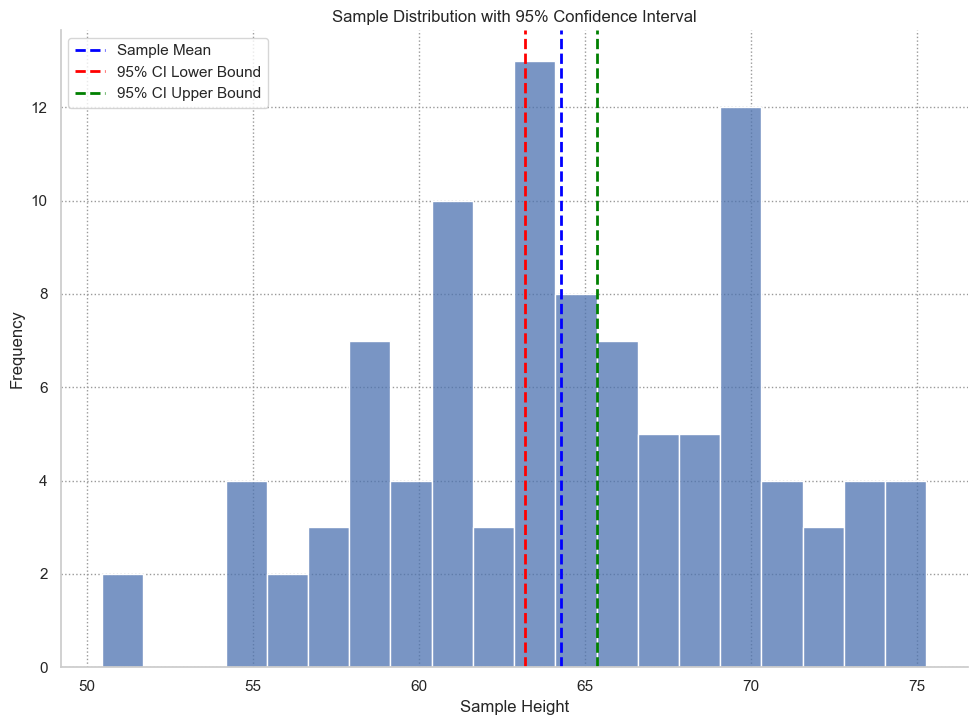

In [37]:
sample_size = 100
heights = np.random.normal(POP_MU, POP_SIGMA, sample_size)
SE = np.std(heights)/np.sqrt(sample_size)
(l, u) = stats.norm.interval(0.95, loc=mean_height, scale=SE)

print(l, u)
ax = sb.histplot(heights, bins=20)
ax.axvline(mean_height, color='blue', linestyle='dashed', linewidth=2, label='Sample Mean')
ax.axvline(l, color='red', linestyle='dashed', linewidth=2, label='95% CI Lower Bound')
ax.axvline(u, color='green', linestyle='dashed', linewidth=2, label='95% CI Upper Bound')

ax.legend()
ax.set(xlabel="Sample Height", ylabel="Frequency", title="Sample Distribution with 95% Confidence Interval")
sb.despine()

## Miscalibration and Violation of Assumptions

The computation of a standard deviation, standard error, and confidence interval all rely on certain assumptions. If these assumptions are violated, then a 95% confidence interval doesn't imply that in 95% of the runs the true parameter will be contained inside the interval. In those cases, it's said that the model is **miscalibrated**.

### Example: Autocorrelated Data

If the data generating process is autocorrelated, then standard deviation estimates will be wrong. This is due to autocorrelated processes producing more extreme values than normally distributed processes. Intuitively, this is due to new values being dependent on previous values, so series that drift away from the mean are likely to stay far from the mean.

As a proof, generate some autocorrelated data according to the following process:
$$
\begin{align*}
    X_{t} &= \theta X_{t-1} + \epsilon \\
    \epsilon &\sim \mathcal{N}(0, 1)
\end{align*}
$$

/home/venatio/documents/projects/quantopian_lectures/.venv/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/venatio/documents/projects/quantopian_lectures/.venv/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 0, 'Period t'), Text(0, 0.5, 'Observation X[t]')]

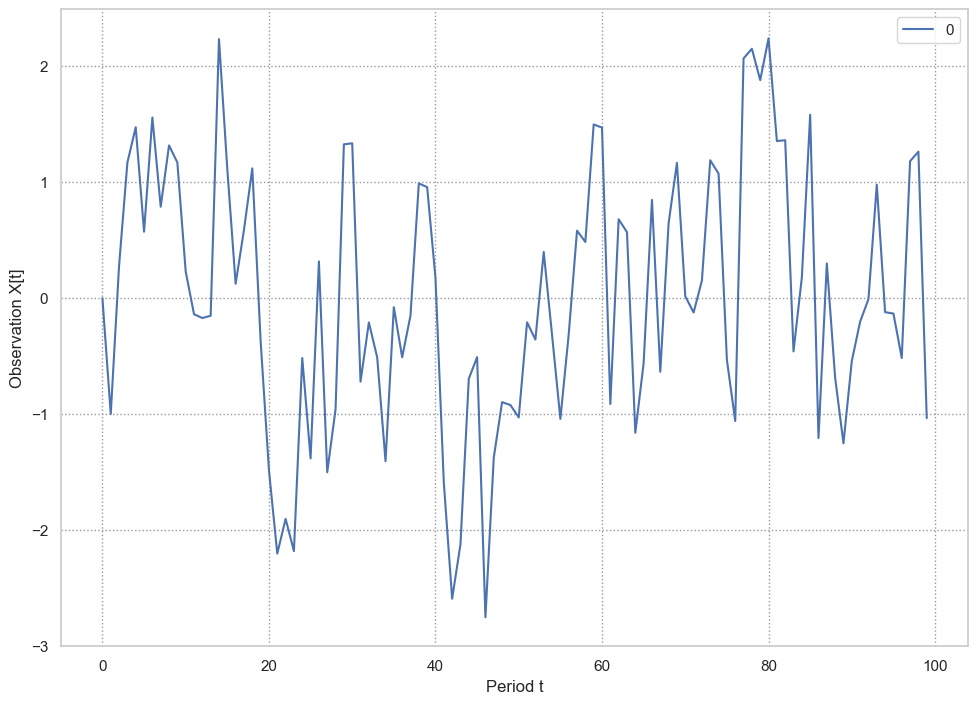

In [41]:
def generate_autocorrelated_data(theta, mu, sigma, N):
    X = np.zeros((N, 1))
    for t in range(1, N):
        X[t] = theta * X[t-1] + np.random.normal(loc=mu, scale=sigma)
    return X

X = generate_autocorrelated_data(0.5, 0, 1, 100)

sb.lineplot(data=X).set(xlabel="Period t", ylabel="Observation X[t]");

It turns out that for larger sample sizes, the sample mean asymptotically converges to zero. This is because the process is still centered around zero. To check that this is true, it can be visualized graphically as:

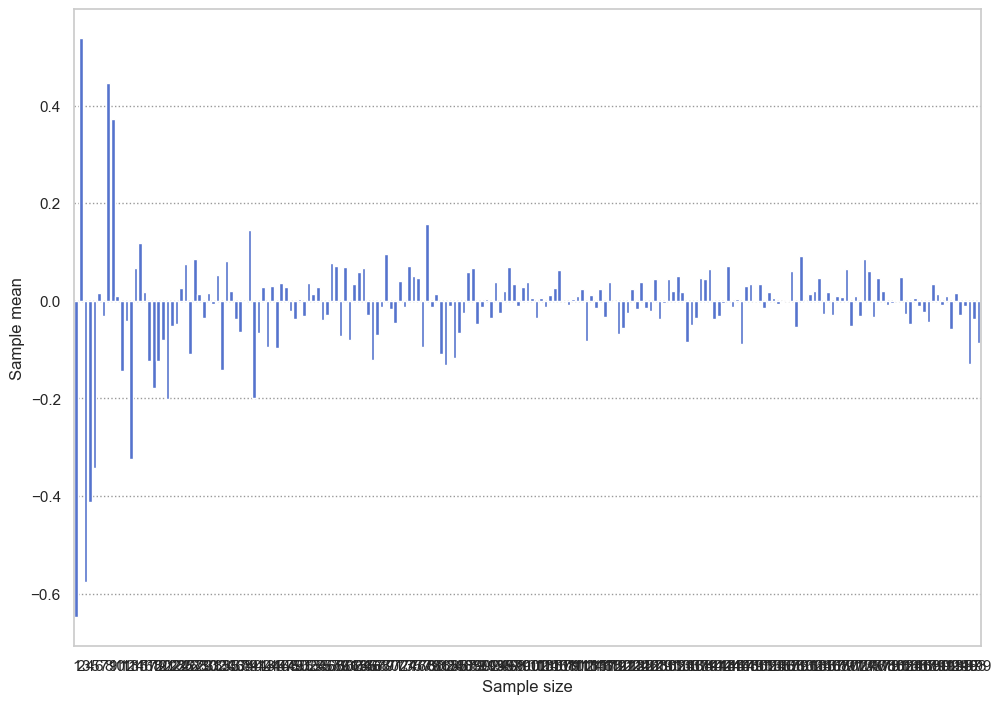

In [58]:
sample_means = np.zeros(200-1)
for i in range(1, 200):
    X = generate_autocorrelated_data(0.5, 0, 1, i*10)
    sample_means[i-1] = np.mean(X)

sample_means_data = pd.DataFrame(list(zip(sample_means, range(1, 200))), columns=["Mean", "Size"])

sb.barplot(sample_means_data, x="Size", y="Mean", color="royalblue").set(xlabel="Sample size", ylabel="Sample mean");

There's definitely some visible convergence, where the mean is:

In [59]:
np.mean(sample_means)

np.float64(-0.009996933233402588)

Which is pretty close to zero. Now that the population mean is known, it's possible to check the calibration of the confidence intervals. Let two functions compute a "naive" interval for some input, and check whether the interval contains the true mean.

In [60]:
def compute_unadjusted_interval(X):
    T = len(X)
    # compute the estimators
    mu = np.mean(X)
    sigma = np.std(X)
    SE = sigma / np.sqrt(T)
    # compute the bounds
    return stats.norm.interval(0.95, loc=mu, scale=SE)

# function to check when the bounds contain 0
def check_unadjusted_coverage(X):
    l, u = compute_unadjusted_interval(X)
    # check
    if l <= 0 and 0 <= u:
        return True
    else:
        return False

1Then, many trials are run where there is data sampling, and then a confidence interval is computed, and lastly verified whether the true parameter is in them. By definition, in 95% of these runs the true parameter should be in there if the intervals are calibrated correctly.

In [61]:
T = 100
trials = 500
times_correct = 0
for i in range(trials):
    X = generate_autocorrelated_data(0.5, 0, 1, T)
    if check_unadjusted_coverage(X):
        times_correct += 1

print(f"Tested coverage: {times_correct/trials}")
print(f"Expected coverage: 0.95")

Tested coverage: 0.754
Expected coverage: 0.95


Clearly, the coverage is wrong. In this case, a Newey-West correction could be done on the standard error estimate to account for autocorrelation. In practice, it's always important to check for the assumptions made. It's quick to check if the data is stationary (which would imply there's no autocorrelation). A normality test such as Jarque Bera would also be a good idea, as it might detect certain properties of the underlying distribution which could violate assumptions in common statistical analyses.